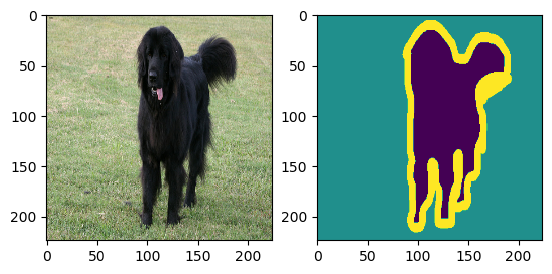

In [1]:
# 数据集处理
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
# from PIL import *

# 环境变量的配置
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


def decode_jpg_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1
    return image


def decode_png_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, [224, 224])
    image -= 1
    return image


def load_images(images_path, labels_path):
    image = decode_jpg_image(images_path)
    label = decode_png_image(labels_path)
    return image, label


def make_dataset():
    images_path = glob.glob(r'F:\data\dataset\images\*.jpg')
    labels_path = glob.glob(r'F:\data\dataset\trimaps\*.png')

    # 对于两个文件路径集合进行相同的乱序操作
    np.random.seed(2022)
    index = np.random.permutation(len(images_path))
    images_path = np.array(images_path)[index]
    labels_path = np.array(labels_path)[index]

    # 划分训练与测试的数据集的数量
    count = len(images_path)
    test_count = int(count * 0.2)
    train_count = count - test_count

    # 构建数据集
    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path))
    train_dataset = dataset.skip(test_count)
    test_dataset = dataset.take(test_count)

    train_dataset = train_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.repeat().shuffle(100).batch(batch_size=8)
    test_dataset = test_dataset.map(load_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size=8)

    return train_dataset, train_count, test_dataset, test_count


if __name__ == '__main__':
    train_data, train_num, test_data, test_num = make_dataset()
    for img, label in train_data.take(1):
        plt.subplot(1, 2, 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
        # plt.imshow(img[0])
        plt.subplot(1, 2, 2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(label[0]))
        # plt.imshow(label[0])
        plt.show()



In [2]:
# 模型构建
import tensorflow as tf
import os

# 环境变量的配置
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


def make_model():
    conv_base = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    layer_names = [
        'block5_conv3',
        'block4_conv3',
        'block3_conv3',
        'block5_pool'
    ]
    layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]
    multi_out_model = tf.keras.models.Model(inputs=conv_base.input, outputs=layers_output)
    multi_out_model.trainable = False

    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    out_block5_conv3, out_block4_conv3, out_block3_conv3, out = multi_out_model(inputs)

    x1 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                         activation='relu')(out)
    x1 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x1)

    x2 = tf.add(x1, out_block5_conv3)
    x2 = tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                         activation='relu')(x2)
    x2 = tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(x2)

    x3 = tf.add(x2, out_block4_conv3)
    x3 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                         activation='relu')(x3)
    x3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(x3)

    x4 = tf.add(x3, out_block3_conv3)

    x5 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                         activation='relu')(x4)
    x5 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(x5)
    prediction = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding='same',
                                                 activation='softmax')(x5)

    model = tf.keras.models.Model(inputs=inputs, outputs=prediction)
    model.summary()

    return model


if __name__ == '__main__':
    mod = make_model()



Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 14, 14, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 14, 14, 512)  2359808     functional_1[0][3]               
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 512)  2359808     conv2d_transpose[0][0]           
_______________________________________________________________________________________

In [ ]:
# 模型训练
import tensorflow as tf
import os
# from data_loader import make_dataset
# from model_loader import make_model

# 环境变量的配置
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# 加载数据
train_dataset, train_count, test_dataset, test_count = make_dataset()

# 加载模型
model = make_model()

# 模型的编译
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

# 模型的训练
model.fit(train_dataset,
          epochs=10,
          steps_per_epoch=train_count // 8,
          validation_data=test_dataset,
          validation_steps=test_count // 8)

# 模型的保存
model.save(r'model_data/model.h5')



Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       [(None, 14, 14, 512) 14714688    input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_5 (Conv2DTrans (None, 14, 14, 512)  2359808     functional_5[0][3]               
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 512)  2359808     conv2d_transpose_5[0][0]         
_______________________________________________________________________________________

In [ ]:
# 模型预测
import tensorflow as tf
import os
# from data_loader import decode_jpg_image
import matplotlib.pyplot as plt

# 环境变量的配置
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# 模型的加载
model = tf.keras.models.load_model(r'model_data/model.h5')

while True:
    path = input('请输入图片的路径：')
    image = decode_jpg_image(path)
    model_input = tf.expand_dims(image, axis=0)
    mask = model.predict(model_input)
    mask = tf.squeeze(mask)
    mask = tf.expand_dims(tf.argmax(mask, axis=-1), axis=-1)
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask))
    plt.show()

